In [1]:
'''
Note--

1) Dont forget to change the model path
2) Load the data in the same format as given in sample notebook, 
   That is X_train/x_valid should of shpae (N,32,32,2)
'''

'\nNote--\n\n1) Dont forget to change the model path\n2) Load the data same as given in sample notebook, \n   That is X_train/x_valid should of shpae (N,32,32,2)\n     \n'

In [21]:
model_path="/content/ViT_Final_model.pth"

# Basic setup and importing required libraries

In [3]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O Electron.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O Photon.hdf5

--2021-11-28 16:12:02--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 188.184.97.72, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘Electron.hdf5’

Electron.hdf5       100%[===================>]  82.98M  18.8MB/s    in 4.6s    

Last-modified header invalid -- time-stamp ignored.
2021-11-28 16:12:09 (17.8 MB/s) - ‘Electron.hdf5’ saved [87010508/87010508]

--2021-11-28 16:12:09--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.142.53.35, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (76M) [application/octet-stream]
Saving to: ‘Photon.hdf5’

Photon.hdf

In [4]:
! pip install einops

In [5]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


In [6]:
np.random.seed(1337)  # for reproducibility

img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']


In [7]:
device =torch.device("cuda" if torch.cuda.is_available() else "Cpu")

# Dataset Preparation

In [8]:
filename = "./Electron.hdf5"
data1 = h5py.File(filename, "r")
Y1 = data1["y"]
X1 = data1["X"]
filename = "./Photon.hdf5"
data0 = h5py.File(filename, "r")
Y0 = data0["y"]
X0 = data0["X"]
X_final = np.concatenate((X0[:], X1[:]), axis=0)
Y_final = np.concatenate((Y0[:], Y1[:]), axis=0)


num_classes = 2
input_shape = (32, 32, 2) #Using the Hit-Energy channel only



In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    Y_final,
    test_size=0.2,
    random_state=42,stratify=Y_final,shuffle=True
)
    
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (338640, 32, 32, 2) - y_train shape: (338640,)
x_test shape: (84660, 32, 32, 2) - y_test shape: (84660,)


In [10]:
data_transforms =transforms.Compose([
            transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        
        ])

In [43]:
class ML4SCI_Dataset():
  def __init__(self,X,Y,in_channels=2):
    self.X=X
    self.Y=Y

    self.data_transforms=data_transforms
  def __len__(self):
      return len(self.X)

  def __getitem__(self,idx):
    return (data_transforms(self.X[idx]),torch.tensor(self.Y[idx],dtype=torch.int))


In [16]:
ML4SCI_Dataset(X_test,y_test)

(84660, 32, 32, 2)


In [36]:
import gc
gc.collect()

3401

# Compiling the model

In [24]:

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 2, patch_size: int = 4, emb_size: int = 128, img_size: int = 32):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 128, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 256,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 128, n_classes: int = 2):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))


In [25]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 1,
                patch_size: int = 4,
                emb_size: int = 128,
                img_size: int = 32,
                depth: int = 12,
                n_classes: int = 1,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        


# Final Evaluation 

In [26]:
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (338640, 32, 32, 2) - y_train shape: (338640,)
x_test shape: (84660, 32, 32, 2) - y_test shape: (84660,)


In [27]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
import gc
gc.collect()

806

In [44]:
def evaluate(X,Y,model_path):
  '''
  Arguments-
  1) X-- Numpy arrays of input images of shape (N,32,32,2)
  2) Y -- Labels of shape (N,)
  3) model_path
  '''

  model=torch.load(model_path).to(device)
  data=ML4SCI_Dataset(X,Y,in_channels=2)
  data_loader= DataLoader(dataset = data, batch_size = 128, shuffle = True)


  a,y_true,y_pred=[],torch.tensor([]),torch.tensor([])
  with torch.no_grad():
      for data, label in data_loader:

          data = data.to(device)
          label = label.to(device)
          label_oh = torch.nn.functional.one_hot(label.long(), num_classes = 2)

          val_output = model(data)
          label_oh = label.type_as(val_output)

          y_pred_val=val_output.argmax(dim=1)

          val_acc = (y_pred_val == label).float().mean()
          y_pred=torch.cat([y_pred.cpu(),val_output[:,1].cpu()],dim=0)
          y_true=torch.cat([y_true.cpu(),label_oh.cpu()],dim=0)

      fpr,tpr,_=roc_curve(y_true,y_pred)
      print(f"Accuracy: {val_acc:.2f} AUC{auc(fpr,tpr):.3f}")

      return fpr,tpr

In [46]:
# print("Evaluating model on Training Dataset")
# train_fpr,train_tpr=evaluate(X_train,y_train,model_path)

Evaluating model on Training Dataset
Accuracy: 0.78 AUC0.773


In [47]:
print("Validation Data")
fpr,tpr=evaluate(X_test,y_test,model_path)

Validation Data
Accuracy: 0.81 AUC0.772


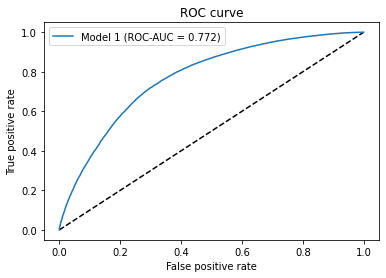

In [48]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(auc(fpr,tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()